In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library("ggpubr")
library(viridis)
library(scales)
library(rstatix)

library(RColorBrewer)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate


Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter




In [2]:
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  if(luminance < 128){
  return('white')
  }else{return('black')}
}

In [3]:

color_annotation <- read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [4]:
meta_data=read.csv("/home/jupyter/BRI_Figures_Final_V2/Dataset/scRNA_meta_data-2024-05-09.csv")
meta_data_subset<-meta_data %>% filter(Covid_exclusion=='no',
                                       sample.visitName%in% c('Flu Year 1 Day 0'))
meta_data_subset<-meta_data_subset %>% mutate(`Age Group`=case_when(cohort.cohortGuid=="BR1"~"Young", TRUE~'Older'))
meta_data_subset$`Age Group`<-factor(meta_data_subset$`Age Group`,levels=c("Young","Older"))

# Read NMF score for Year 1 Day 0 Samples

In [5]:
df<-read.csv("02_NMF_CD4_T_cell_Projection/NMF_Scores_Y1D0_BRI.csv")

In [6]:
df<-df %>% filter(NMF_Scores %in% c('NMF0_Cytotoxic', 'NMF2_Th17',  
                                                    'NMF5_Th2', 'NMF6_Tfh',  
                                                    'NMF8_Cent_Mem', 'NMF11_Th1'))%>% 
                           filter(AIFI_L3 %in% c('CM CD4 T cell',
 'GZMB- CD27+ EM CD4 T cell',
 'KLRF1- GZMB+ CD27- memory CD4 T cell',
 'GZMB- CD27- EM CD4 T cell'))

In [7]:
df_median<-df %>%
  group_by(AIFI_L3, pbmc_sample_id,NMF_Scores) %>%
  summarise(AverageScore_median = median(AverageScore, na.rm = TRUE)) %>%
  spread(NMF_Scores, AverageScore_median) 

`summarise()` has grouped output by 'AIFI_L3', 'pbmc_sample_id'. You can
override using the `.groups` argument.


In [8]:
df<-left_join(df_median,meta_data_subset,by=c('pbmc_sample_id'))

In [11]:
install.packages('ggbreak')

Installing package into ‘/home/jupyter/libb’
(as ‘lib’ is unspecified)



In [12]:
library(ggbreak)


ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846




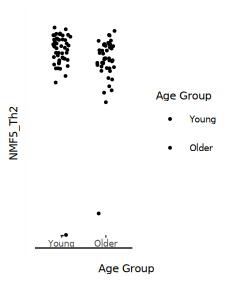

In [35]:
options(repr.plot.width = 50/25.4, repr.plot.height = 60/25.4)

ggplot(df %>% filter(AIFI_L3=="CM CD4 T cell"), aes(x=`Age Group`, y=NMF5_Th2, fill=`Age Group`)) +
geom_point(position = position_jitter(width = 0.2),color="black", size=0.8,stroke=0) +
theme_classic(base_size=6) +
scale_y_break(breaks=c(0.01))

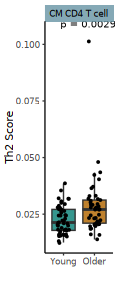

In [24]:
options(repr.plot.width = 25/25.4, repr.plot.height = 60/25.4)

p<-ggplot(df %>% filter(AIFI_L3=="CM CD4 T cell"), aes(x=`Age Group`, y=NMF5_Th2, fill=`Age Group`)) +
    geom_boxplot(outlier.shape = NA,lwd=0.3) +
geom_point(position = position_jitter(width = 0.2),color="black", size=0.8,stroke=0) +
theme_classic(base_size=6) +
scale_y_break(breaks=c(0.05)) +  
stat_compare_means(aes(label = paste0("p = ", after_stat(p.format))),
    size=2,
    label.x=1.25,  
    vjust = -2)+theme(strip.background = element_rect(linewidth = 0))+
    scale_fill_manual(values = c("Older" = '#bf812d', "Young" = '#35978f'))+
    scale_y_continuous(limits = c(NA, NA), 
                       expand = expansion(mult = c(0.05, 0.1)))+
theme(legend.position="none")+
xlab('')+
ylab('Th2 Score')+
facet_wrap(~AIFI_L3,  scale='free_y')

g <- ggplot_gtable(ggplot_build(p))

strips <- which(grepl('strip-', g$layout$name))

pal <- color_vector['CM CD4 T cell']
text_color <- sapply(color_vector['CM CD4 T cell'], is_dark_color)

for (i in seq_along(strips)) {
  k <- which(grepl('rect', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  l <- which(grepl('titleGrob', g$grobs[[strips[i]]]$grobs[[1]]$childrenOrder))
  g$grobs[[strips[i]]]$grobs[[1]]$children[[k]]$gp$fill <-  adjustcolor(pal[i], alpha.f = 0.8)
  g$grobs[[strips[i]]]$grobs[[1]]$children[[l]]$children[[1]]$gp$col <- text_color[i]
}

plot(g)

ggsave('FigureI.pdf',g,width = 25/25.4,height = 45/25.4)